In [1]:
!pip install replicate

import replicate
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 911.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


Import json file from wikihow

In [2]:
import json

from google.colab import files
uploaded = files.upload()

file_name = next(iter(uploaded))

with open(file_name, 'r') as file:
    data = json.load(file)

main_goal = data['title']

wiki_steps = []

for part in data['parts']:
    for step in part['steps']:
        wiki_steps.append(step['headline'])

Saving 1503_soothe-a-teething-baby.json to 1503_soothe-a-teething-baby.json


In [3]:
wiki_steps

["Rub your baby's gums with a clean finger.",
 "Keep your baby's mouth cool.",
 'Invest in a teething device.',
 'Give your baby hard foods.',
 'Dry any drool you see.',
 'Try over-the-counter drugs.',
 'Use teething gels.',
 'Be cautious when trying homeopathic cures.',
 'Know when to see a doctor.',
 'Take your baby to the dentist.',
 "Care for your baby's new teeth.",
 'Prevent tooth decay by feeding your baby a healthy diet.']

In [25]:
os.environ['REPLICATE_API_TOKEN'] = 'r8_e4mEdTT4wmpHuZB2RHxxw8Gr6xAlEWS33mK6e'
api = replicate.Client(api_token=os.environ["REPLICATE_API_TOKEN"])
text = ""
input = {
    "top_p": 1,
    "prompt": main_goal,
    "temperature": 0.75,
    "system_prompt": "You are a helpful assistant that helps users break down their goals into smaller steps to help them achieve their goal. Be very concise and do not go over 10 words for each sentence For example, if the user wants to lose weight, you can list 'Exercise regularly'.",
    "max_new_tokens": 800,
    "repetition_penalty": 1
}

for event in api.stream(
    "meta/llama-2-7b-chat",
    input=input
): text += str(event)

In [26]:
print(text)

 Sure, I'd be happy to help! Here are some steps you can take to help soothe a teething baby:

1. Provide relief with a cold compress.
2. Offer teething toys to chew on.
3. Try swaddling or holding the baby.
4. Use over-the-counter pain relievers.
5. Massage the baby's gums.
6. Try using a teething gel or ointment.
7. Keep the baby's room cool and dark.
8. Offer the baby a cold pacifier.
9. Try using aromatherapy with lavender oil.
10. Keep the baby hydrated with water.


Put Llama 2 output into a list

In [27]:
import re

llama_steps = []

lines = text.splitlines()

pattern = re.compile(r'^\d+\.\s+(.*)')

for line in lines:
    match = pattern.match(line)
    if match:
        step_text = match.group(1)
        llama_steps.append(step_text)

In [28]:
llama_steps

['Provide relief with a cold compress.',
 'Offer teething toys to chew on.',
 'Try swaddling or holding the baby.',
 'Use over-the-counter pain relievers.',
 "Massage the baby's gums.",
 'Try using a teething gel or ointment.',
 "Keep the baby's room cool and dark.",
 'Offer the baby a cold pacifier.',
 'Try using aromatherapy with lavender oil.',
 'Keep the baby hydrated with water.']

Dynamic Time Warping? + BLEU Scores

In [29]:
!pip install nltk fastdtw dtaidistance

import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
from dtaidistance import dtw
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pandas as pd
from nltk.translate.bleu_score import SmoothingFunction
import itertools

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Tokenize sentences
wiki_tokenized = [nltk.word_tokenize(sentence) for sentence in wiki_steps]
llama_tokenized = [nltk.word_tokenize(sentence) for sentence in llama_steps]

smoothing_function = SmoothingFunction().method1

# BLEU score matrix
bleu_matrix = np.zeros((len(wiki_steps), len(llama_steps)))

for i, ref in enumerate(wiki_tokenized):
    for j, hyp in enumerate(llama_tokenized):
        bleu_matrix[i, j] = sentence_bleu([ref], hyp, smoothing_function=smoothing_function)

# Display the BLEU similarity matrix as a DataFrame for better readability
bleu_df = pd.DataFrame(bleu_matrix, index=[f"wiki_{i}" for i in range(len(wiki_steps))],
                       columns=[f"llama_{j}" for j in range(len(llama_steps))])

print("BLEU Similarity Matrix:")
print(bleu_df)

BLEU Similarity Matrix:
          llama_0   llama_1   llama_2   llama_3   llama_4   llama_5   llama_6  \
wiki_0   0.050360  0.021518  0.025589  0.019766  0.111472  0.025725  0.050220   
wiki_1   0.033032  0.033032  0.039281  0.036015  0.080876  0.027776  0.063767   
wiki_2   0.039281  0.039281  0.033032  0.043989  0.040825  0.065006  0.023980   
wiki_3   0.033032  0.033032  0.039281  0.043989  0.048549  0.027776  0.028518   
wiki_4   0.033032  0.033032  0.033032  0.043989  0.040825  0.027776  0.023980   
wiki_5   0.033032  0.033032  0.039281  0.063894  0.040825  0.033032  0.023980   
wiki_6   0.033032  0.039281  0.033032  0.063894  0.040825  0.033032  0.023980   
wiki_7   0.033032  0.033032  0.033032  0.036015  0.034557  0.027776  0.023980   
wiki_8   0.039281  0.039281  0.033032  0.036015  0.034557  0.033032  0.023980   
wiki_9   0.033032  0.039281  0.043472  0.036015  0.045480  0.027776  0.031560   
wiki_10  0.028634  0.028634  0.034052  0.029487  0.068460  0.027776  0.056122   
wiki

In [31]:
# Calculate the maximum BLEU score for each llama entry
max_bleu_scores = np.max(bleu_matrix, axis=0)

# Calculate the average of the maximum BLEU scores
average_max_bleu = np.mean(max_bleu_scores)


max_indices = np.argmax(bleu_matrix, axis=0)

# Print the corresponding sentence matchups
print("Maximum BLEU score sentence matchups:")
for j, max_index in enumerate(max_indices):
    print(f"LLama: {llama_steps[j]} -> Wiki: {wiki_steps[max_index]}")

print("\nMaximum BLEU scores for each 'llama' entry:")
print(max_bleu_scores)
print("\nAverage of the maximum BLEU scores:", average_max_bleu)

Maximum BLEU score sentence matchups:
LLama: Provide relief with a cold compress. -> Wiki: Rub your baby's gums with a clean finger.
LLama: Offer teething toys to chew on. -> Wiki: Invest in a teething device.
LLama: Try swaddling or holding the baby. -> Wiki: Take your baby to the dentist.
LLama: Use over-the-counter pain relievers. -> Wiki: Try over-the-counter drugs.
LLama: Massage the baby's gums. -> Wiki: Rub your baby's gums with a clean finger.
LLama: Try using a teething gel or ointment. -> Wiki: Invest in a teething device.
LLama: Keep the baby's room cool and dark. -> Wiki: Keep your baby's mouth cool.
LLama: Offer the baby a cold pacifier. -> Wiki: Prevent tooth decay by feeding your baby a healthy diet.
LLama: Try using aromatherapy with lavender oil. -> Wiki: Try over-the-counter drugs.
LLama: Keep the baby hydrated with water. -> Wiki: Keep your baby's mouth cool.

Maximum BLEU scores for each 'llama' entry:
[0.05035983 0.03928147 0.04347209 0.06389431 0.11147237 0.065005

Plot the maximum Bleu Scores

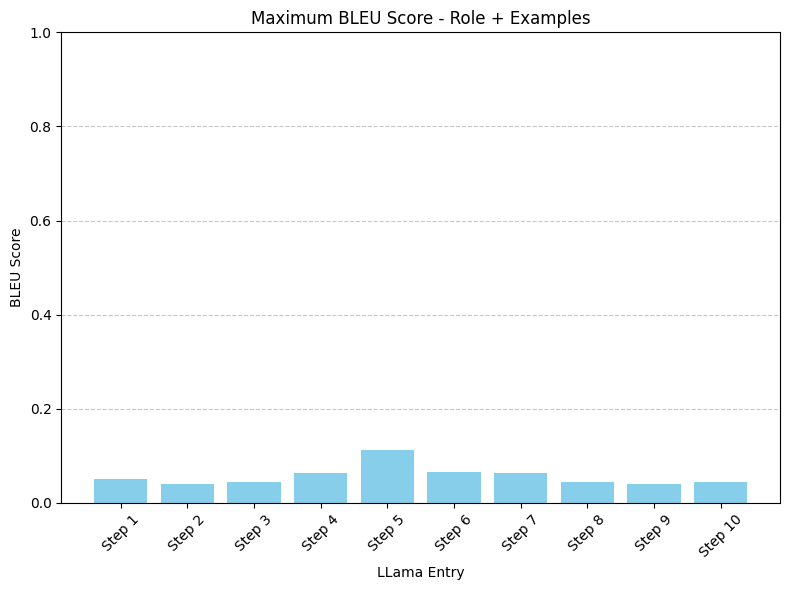

In [32]:
import matplotlib.pyplot as plt

# Plot the maximum BLEU scores
plt.figure(figsize=(8, 6))
plt.bar(range(len(llama_steps)), max_bleu_scores, color='skyblue')
plt.xlabel('LLama Entry')
plt.ylabel('BLEU Score')
plt.title('Maximum BLEU Score - Role + Examples')
plt.xticks(range(len(llama_steps)), ['Step ' + str(i+1) for i in range(len(llama_steps))], rotation=45)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()